This file is for exploring how the data is structured in the given files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import loguru
import os

In [28]:
# TODO: Clarify apparent zero-measurements on the draft sensors?
# TODO: sanity check that ranges for each sensor make sense

Set the working dir and define paths

In [ ]:
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
input_dir = os.path.join(parent_dir, 'raw', 'unzipped')
output_path = os.path.join(parent_dir, 'joined', 'all_measurements.csv')
sensor_dictionary_path = os.path.join(parent_dir, 'metadata', 'Metrics registration.csv')
sensor_dict_df = pd.read_csv(sensor_dictionary_path)

logger = loguru.logger

## 1. Loading files

### 1.2. Minor Cleaning

In [4]:
# set the value for "unit" of Vessel Propeller Shaft Revolutions to "revs"
sensor_dict_df.loc[sensor_dict_df['quantity_name'] == 'Vessel Propeller Shaft Revolutions', 'unit'] = 'revs'

# save it to a csv file
sensor_dict_df.to_csv(sensor_dictionary_path, index=False)

### 1.3. Joining tables

In [21]:
def load_single_data_file(file_path, header, sensor_dict_df):

    # find the last part ("...", followed by everything after the last slash) of the file path for logging
    trunc_file_path = f"{file_path.split(os.sep)[-2]}/{os.path.basename(file_path)}"

    # load df from file path
    df = pd.read_csv(file_path, names=header)
    logger.info(f'Loaded data from {trunc_file_path} with shape: {df.shape}')

    # Add the two columns from the sensor dictionary df "quantity_name" and "source_name" by left joining on "qid_mapping" and "sensor_id"
    df = df.merge(sensor_dict_df[['qid_mapping', 'quantity_name', 'source_name', 'unit']], left_on='qid_mapping', right_on='qid_mapping', how='left')
    logger.info(f'joined additional columns onto {trunc_file_path}. shape: {df.shape}')

    # convert the column 'utc_timestamp' to datetime
    df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

    # Sort the rows by the UTC timestamp
    df = df.sort_values(by='utc_timestamp').reset_index(drop=True)

    return df

def combine_data_files(input_dir, header, sensor_dict_df):

    df_combined = pd.DataFrame(columns=header + ['quantity_name', 'source_name', 'unit'])

    for i in range(1, 13):
        file_path = os.path.join(input_dir, str(i), f'{i}.csv')
        df = load_single_data_file(file_path, header, sensor_dict_df)
        if list(df.columns) == list(df_combined.columns):
            df_combined = pd.concat([df_combined, df], ignore_index=True)
            logger.info(f'Appended data from file number: {i}. shape of combined df: {df_combined.shape}')
        else:
            logger.error(f'Column names do not match for file: {file_path}. Stopped merging.')
            logger.error(f'columns in combined df: {df_combined.columns}')
            logger.error(f'columns in current df: {df.columns}')
            raise ValueError('Column names do not match.')
        
    # move "value" to the rightmost column
    value_col = df_combined.pop('value')
    df_combined['value'] = value_col

    # Calculate the time since last measurement for a given measurement quantity (qid_mapping)
    df_combined['time_since_last_measurement'] = df_combined.groupby('qid_mapping')['utc_timestamp'].diff()

    return df_combined

In [22]:
header = ['utc_timestamp', 'qid_mapping', 'value']
sensor_dict_df = pd.read_csv(sensor_dictionary_path)

Appending single files into one long dataframe with all observations

In [24]:
df_combined = combine_data_files(input_dir, header, sensor_dict_df)

2025-11-04 11:15:44.736 | INFO     | __main__:load_single_data_file:8 - Loaded data from 1/1.csv with shape: (3657054, 3)
2025-11-04 11:15:45.657 | INFO     | __main__:load_single_data_file:12 - joined additional columns onto 1/1.csv. shape: (3657054, 6)
C:\Users\August Bjerg-Heise\AppData\Local\Temp\ipykernel_12764\2179849115.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_combined, df], ignore_index=True)
2025-11-04 11:15:54.304 | INFO     | __main__:combine_data_files:31 - Appended data from file number: 1. shape of combined df: (3657054, 6)
2025-11-04 11:16:03.527 | INFO     | __main__:load_single_data_file:8 - Loaded data from 2/2.csv with shape: (3510816, 3)
2025-11-04 11:16:04.403 | INFO     | __main_

## 2. Summary

In [ ]:
# Make a summary table with a nested structure that calculates the timespan between the first and last measurement of each sensor. The rows should be grouped by: 1. the "source_name", then 2. "quantity_name", and finally 3. "qid_mapping"
def summarize_sensor_indicators(combined_df):
    summary = combined_df.groupby(['source_name', 'quantity_name', 'qid_mapping']).agg(
        total_measurements=('utc_timestamp', 'count'),
        timespan_days=('utc_timestamp', lambda x: (x.max() - x.min()).days),
        min_value=('value', 'min'),
        max_value=('value', 'max'),
        mean_value=('value', 'mean'),
        std_value=('value', 'std'),
        avg_seconds_between_measurements=('time_since_last_measurement', lambda x: x.mean().total_seconds()),  # in seconds
        most_frequent_seconds_between_measurements=('time_since_last_measurement', lambda x: x.mode()[0].total_seconds())  # in seconds
    )

    # add a unit column by looking up the unit in the qid_mapping from the sensor dictionary
    sensor_dict_df = pd.read_csv(sensor_dictionary_path)
    summary['unit'] = summary.index.get_level_values('qid_mapping').map(
        sensor_dict_df.set_index('qid_mapping')['unit']
    )

    # Drop the qid_mapping column for aesthetics
    # summary = summary.reset_index(level='qid_mapping', drop=True)

    return summary

In [26]:
sensor_summary = summarize_sensor_indicators(df_combined)
sensor_summary.reset_index(inplace=True)

sensor_summary = sensor_summary.style.format({
    'total_measurements': '{:d}',
    'timespan_days': '{:d}',
    'min_value': '{:.2f}',
    'max_value': '{:.7f}',
    'mean_value': '{:.7f}',
    'std_value': '{:.7f}',
    'avg_time_between_measurements': '{:.2f}',
    'most_frequent_time_between_measurements': '{:.2f}'
})

sensor_summary

,source_name,quantity_name,qid_mapping,total_measurements,timespan_days,min_value,max_value,mean_value,std_value,avg_time_between_measurements,most_frequent_time_between_measurements,unit
0,Control Alarm Monitoring System,Main Engine Rotational Speed,3::0::1::0_1::2::0::8::0_1::0::6::0_8,1882493,365,-68.30,108.9000000,64.1438928,35.8814737,16.80,15.00,rpm
1,Control Alarm Monitoring System,Vessel Hull Aft Draft,3::0::1::0_1::1::0::2::0_11::0::2::0_8,1882487,365,0.00,0.0000000,0.0000000,0.0000000,16.80,15.00,m
2,Control Alarm Monitoring System,Vessel Hull Fore Draft,3::0::1::0_1::1::0::2::0_11::0::1::0_8,1882876,365,0.00,0.0000000,0.0000000,0.0000000,16.79,15.00,m
3,Control Alarm Monitoring System,Vessel Hull MidP Draft,3::0::1::0_1::1::0::2::0_11::0::3::0_8,1882871,365,0.00,0.0000000,0.0000000,0.0000000,16.79,15.00,m
4,Control Alarm Monitoring System,Vessel Hull MidS Draft,3::0::1::0_1::1::0::2::0_11::0::4::0_8,1882884,365,0.00,0.0000000,0.0000000,0.0000000,16.79,15.00,m
5,Instrument Anemometer,Vessel External Conditions Wind Relative Angle,2::0::1::0_1::1::0::7::0_2::0::15::22_8,1977274,365,0.00,359.0000000,204.0812710,138.4688858,15.99,15.00,degrees
6,Instrument Anemometer,Vessel External Conditions Wind Relative Speed,2::0::1::0_1::1::0::7::0_1::0::4::22_8,1975954,365,0.00,70.4000000,19.1619881,10.8648863,16.00,15.00,knots
7,Instrument Echosounder,Vessel Hull Relative To Transducer Water Depth,2::0::4::0_1::1::0::2::0_37::0::2::0_8,586021,365,0.70,830.6000000,23.5403003,42.2212756,53.96,15.00,m
8,Instrument GPS 1,Vessel Hull Over Ground Speed,2::0::6::1_1::1::0::2::0_1::0::1::0_8,1982354,365,0.00,15.3000000,8.5319035,4.8039247,15.95,15.00,knots
9,Instrument Gyrocompass,Vessel Hull Heading True Angle,2::0::5::0_1::1::0::2::0_2::0::8::21_8,1981852,365,0.00,359.9000000,164.6850309,102.8133574,15.96,15.00,degrees


## 3. Sanity Checks

### 3.1. Zero values for draft

In [40]:
check_file_path = os.path.join(parent_dir, 'raw/unzipped/12/12.csv')

qid_mappings = {
    'hull_aft_draft_qid': '3::0::1::0_1::1::0::2::0_11::0::2::0_8',
    'hull_fore_draft_qid': '3::0::1::0_1::1::0::2::0_11::0::1::0_8', 
    'hull_midp_draft_qid': '3::0::1::0_1::1::0::2::0_11::0::3::0_8',
    'hull_mids_draft_qid': '3::0::1::0_1::1::0::2::0_11::0::4::0_8'
}

# loop through each qid_mapping and checking if observations consist of solely 0 values
for variable in qid_mappings:
    filtered_df = df_combined[df_combined['qid_mapping'] == qid_mappings[variable]]
    print(f"n for {variable}: {filtered_df.shape[0]}")
    if filtered_df['value'].sum() == 0:
        print(f"All values for {variable} are 0.")

n for hull_aft_draft_qid: 1882487
All values for hull_aft_draft_qid are 0.
n for hull_fore_draft_qid: 1882876
All values for hull_fore_draft_qid are 0.
n for hull_midp_draft_qid: 1882871
All values for hull_midp_draft_qid are 0.
n for hull_mids_draft_qid: 1882884
All values for hull_mids_draft_qid are 0.


As seen above, there the draft sensors show consistent 0-measurements

In [ ]:
def check_values_at_zero_draft(combined_df, desired_draft_qid, sensor_qid):
    
    draft_df = combined_df[combined_df['qid_mapping'] == desired_draft_qid]
    logger.info(f'shape of df for draft qid {desired_draft_qid}: {draft_df.shape}')
    draft_name = draft_df['quantity_name'].iloc[0]

    zero_draft_measurements = draft_df[draft_df['value'] == 0]
    logger.info(f'number of zero draft measurements for draft qid {desired_draft_qid}: {zero_draft_measurements.shape[0]}')

    sensor_df = combined_df[combined_df['qid_mapping'] == sensor_qid]
    sensor_name = sensor_df['quantity_name'].iloc[0]
    logger.info(f'shape of df for sensor qid {sensor_qid}: {sensor_df.shape}')

    # left join zero_draft_measurements with sensor_df on utc timestamp to find corresponding sensor measurements at zero draft
    merged_df = pd.merge(sensor_df, zero_draft_measurements, on='utc_timestamp', how='left', suffixes=(f'_{sensor_name}', f'_{draft_name}'))
    logger.info(f'number of sensor measurements at zero draft for sensor qid {sensor_qid}: {merged_df.shape[0]}')

    # drop NaN values from merged_df to only keep rows where there are exact corresponding measurements
    clean_merged_df = merged_df.dropna()
    logger.info(f'dropped rows with at least one NaN value ({merged_df.shape[0]} - {clean_merged_df.shape[0]}) for sensor qid {sensor_qid}')

    return clean_merged_df

As seen below, there are plenty of instances of zero draft measurements where the speed is non-zero

In [ ]:
check_df = check_values_at_zero_draft(df_combined, hull_mids_draft_qid, '2::0::6::1_1::1::0::2::0_1::0::1::0_8')
check_df.describe()

2025-11-04 11:03:58.312 | INFO     | __main__:check_values_at_zero_draft:4 - shape of df for draft qid 3::0::1::0_1::1::0::2::0_11::0::4::0_8: (1882884, 7)
2025-11-04 11:03:58.526 | INFO     | __main__:check_values_at_zero_draft:8 - number of zero draft measurements for draft qid 3::0::1::0_1::1::0::2::0_11::0::4::0_8: 1882884
2025-11-04 11:04:02.034 | INFO     | __main__:check_values_at_zero_draft:12 - shape of df for sensor qid 2::0::6::1_1::1::0::2::0_1::0::1::0_8: (1982354, 7)
2025-11-04 11:04:02.754 | INFO     | __main__:check_values_at_zero_draft:16 - number of sensor measurements at zero draft for sensor qid 2::0::6::1_1::1::0::2::0_1::0::1::0_8: 1982354
2025-11-04 11:04:03.349 | INFO     | __main__:check_values_at_zero_draft:20 - dropped rows with at least one NaN value (1982354 - 127496) for sensor qid 2::0::6::1_1::1::0::2::0_1::0::1::0_8


,value_Vessel Hull Over Ground Speed,time_since_last_measurement_Vessel Hull Over Ground Speed,value_Vessel Hull MidS Draft,time_since_last_measurement_Vessel Hull MidS Draft
count,127496.000000,127496,127496.0,127496
mean,9.092524,133 days 19:24:10.160259960,0.0,133 days 19:24:10.168259960
std,4.174194,107 days 04:14:53.652019904,0.0,107 days 04:14:53.652019904
min,0.000000,0 days 00:00:45,0.0,0 days 00:00:45.008000
25%,8.800000,33 days 11:38:11.256000,0.0,33 days 11:38:11.264000
50%,10.600000,120 days 03:09:22.506000,0.0,120 days 03:09:22.514000
75%,11.700000,218 days 18:12:07.506000,0.0,218 days 18:12:07.514000
max,15.000000,365 days 23:57:29.993000,0.0,365 days 23:57:30.001000


Scatterplot further confirms my suspicion

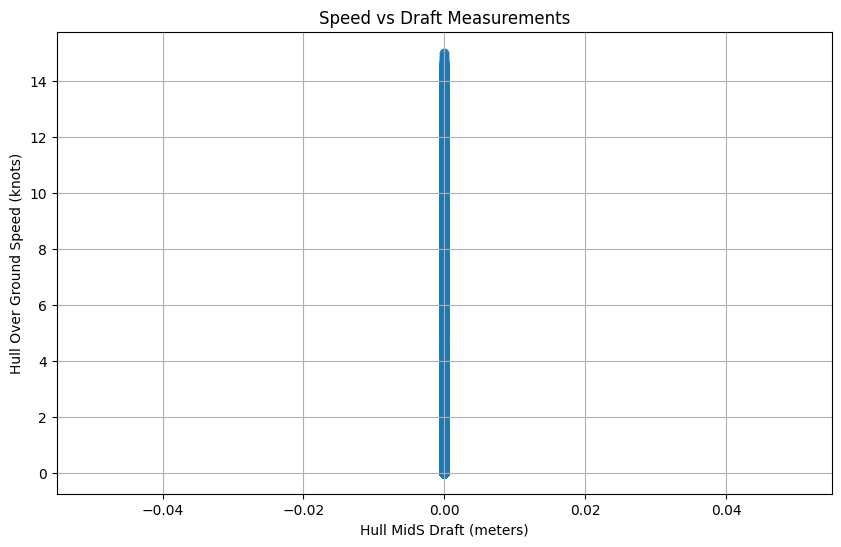

In [ ]:
# make a scatterplot from combined_df showing the speed vs the draft 
plt.figure(figsize=(10, 6))
plt.scatter(check_df['value_Vessel Hull MidS Draft'], check_df['value_Vessel Hull Over Ground Speed'], alpha=0.5)
plt.title('Speed vs Draft Measurements')
plt.xlabel('Hull MidS Draft (meters)')
plt.ylabel('Hull Over Ground Speed (knots)')
plt.grid()
plt.show()

### 3.2. Missing unit for Vessel Propeller Shaft Revolutions

In [ ]:
prop_revs_qid_map = '2::0::11::0_1::1::0::3::0_12::0::1::0_8'

prop_revs_observations = df_combined[df_combined['qid_mapping'] == prop_revs_qid_map]

prop_revs_observations.head()

,utc_timestamp,qid_mapping,quantity_name,source_name,unit,value,time_since_last_measurement
32,2024-01-01 00:00:00.121000+00:00,2::0::11::0_1::1::0::3::0_12::0::1::0_8,Vessel Propeller Shaft Revolutions (cumulative),Instrument Torquemeter,revs,5.015995e+09,365 days 23:59:44.892000
55,2024-01-01 00:00:15.022000+00:00,2::0::11::0_1::1::0::3::0_12::0::1::0_8,Vessel Propeller Shaft Revolutions (cumulative),Instrument Torquemeter,revs,5.015995e+09,365 days 23:59:29.991000
70,2024-01-01 00:00:30.012000+00:00,2::0::11::0_1::1::0::3::0_12::0::1::0_8,Vessel Propeller Shaft Revolutions (cumulative),Instrument Torquemeter,revs,5.015995e+09,365 days 23:59:15.001000
91,2024-01-01 00:00:45.012000+00:00,2::0::11::0_1::1::0::3::0_12::0::1::0_8,Vessel Propeller Shaft Revolutions (cumulative),Instrument Torquemeter,revs,5.015995e+09,365 days 23:59:00.001000
122,2024-01-01 00:01:00.040000+00:00,2::0::11::0_1::1::0::3::0_12::0::1::0_8,Vessel Propeller Shaft Revolutions (cumulative),Instrument Torquemeter,revs,5.015995e+09,365 days 23:58:44.973000


In [ ]:
sensor_dict_df[sensor_dict_df['qid_mapping'] == prop_revs_qid_map]

,qid_mapping,quantity_name,source_name,unit
19,2::0::11::0_1::1::0::3::0_12::0::1::0_8,Vessel Propeller Shaft Revolutions (cumulative),Instrument Torquemeter,revs


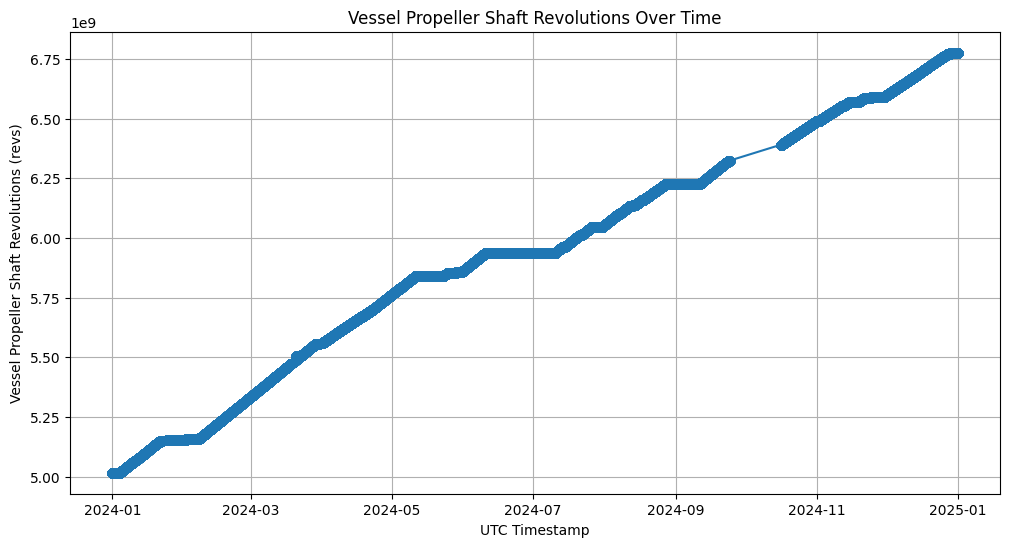

In [ ]:
# check wether the Vessel Propeller Shaft Revolutions are cumulative 

plt.figure(figsize=(12, 6))
plt.plot(prop_revs_observations['utc_timestamp'], prop_revs_observations['value'], marker='o', linestyle='-')
plt.title('Vessel Propeller Shaft Revolutions Over Time')
plt.xlabel('UTC Timestamp')
plt.ylabel('Vessel Propeller Shaft Revolutions (revs)')
plt.grid()
plt.show()

# Yes, they are cumulative

### 3.3. Why mode for last measurement is 0 

Text(0.5, 1.0, 'Histogram of Time Since Last Measurement (in seconds)')

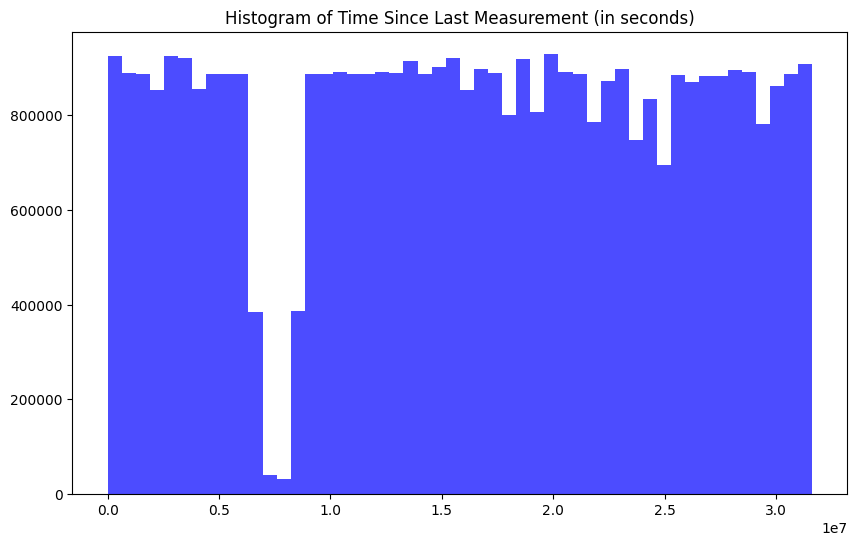

In [ ]:
# Make a histogram of the column for time since last measurement for all measurement sensors
plt.figure(figsize=(10, 6))
plt.hist(df_combined['time_since_last_measurement'].dt.total_seconds().dropna(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Time Since Last Measurement (in seconds)')

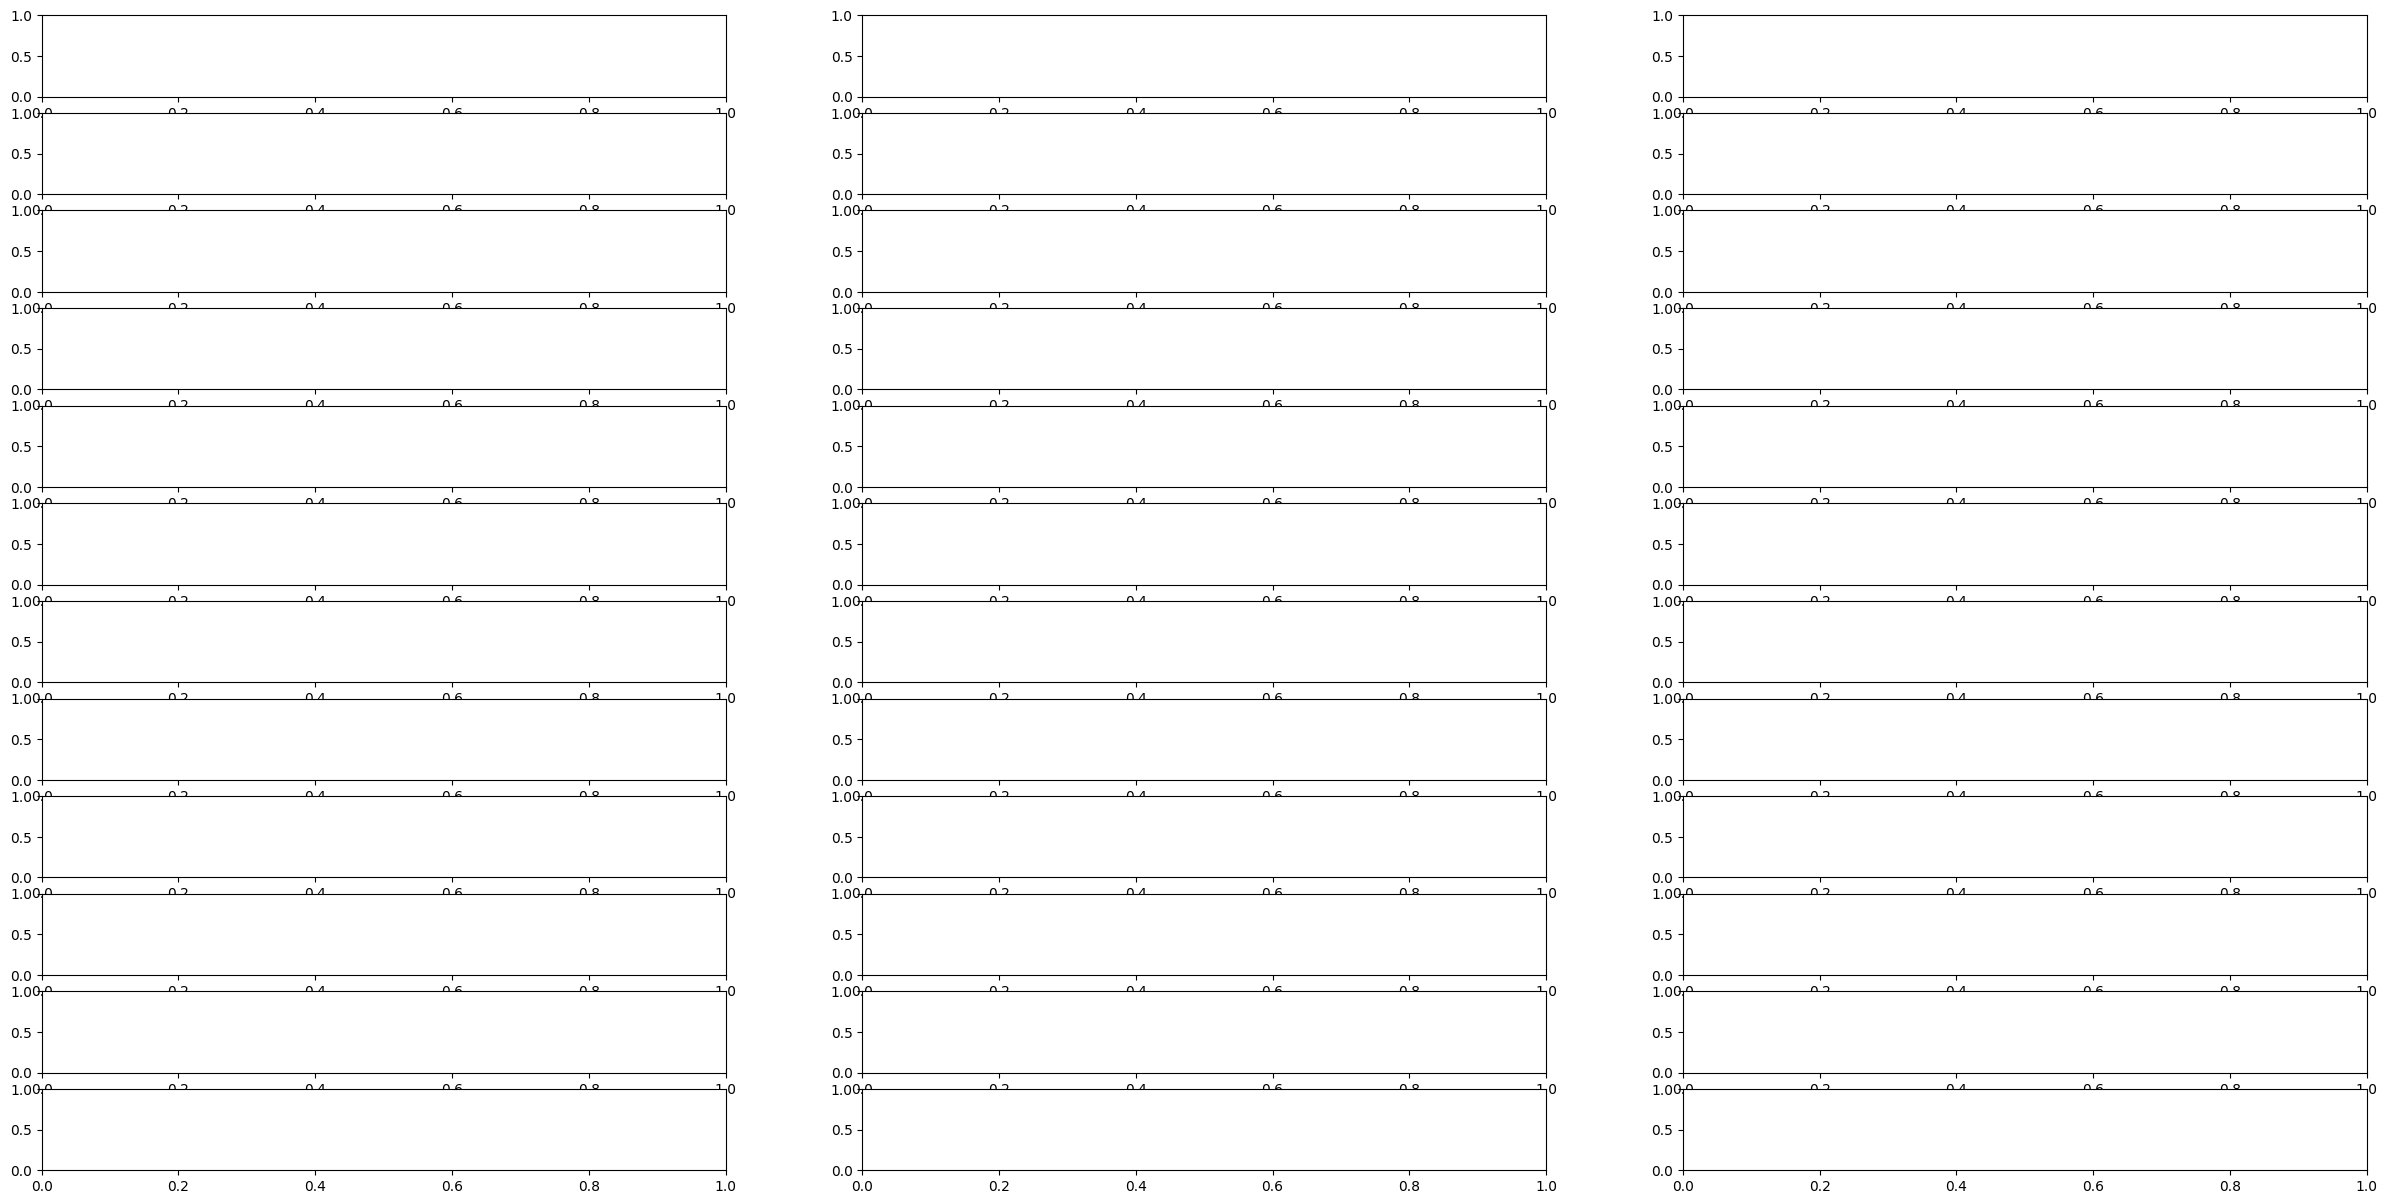

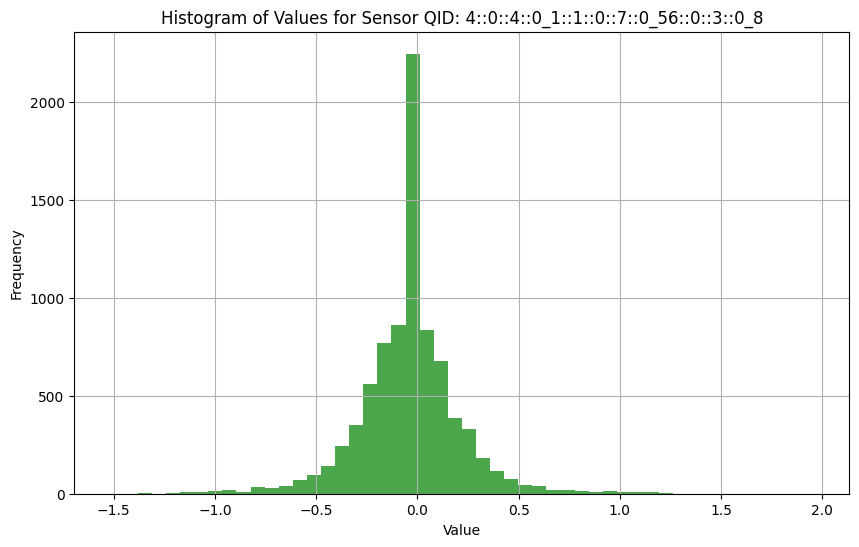

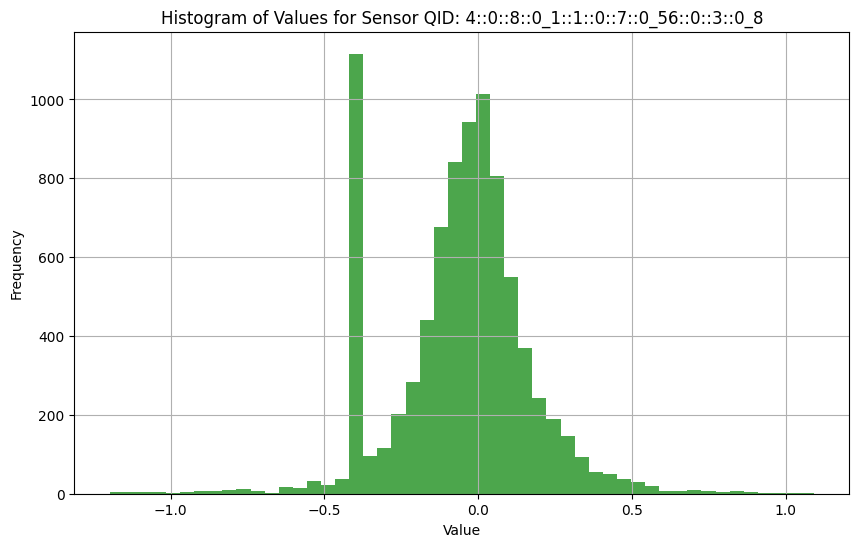

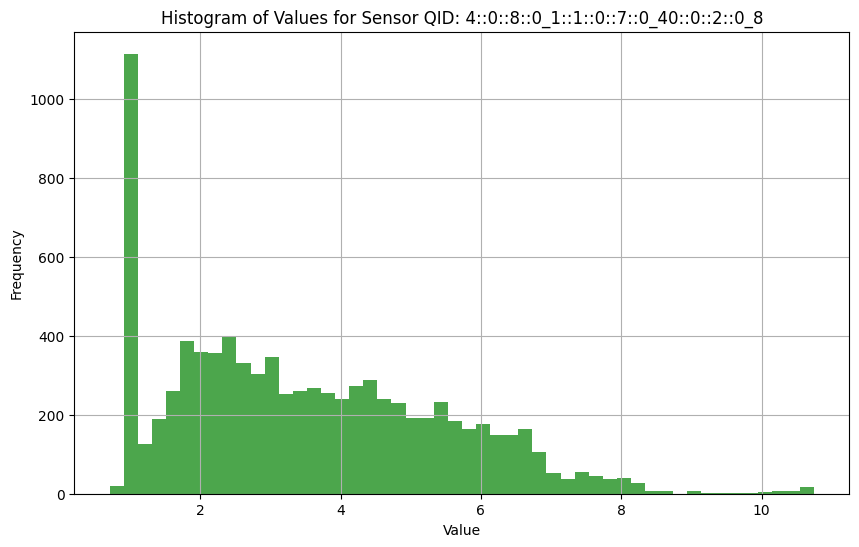

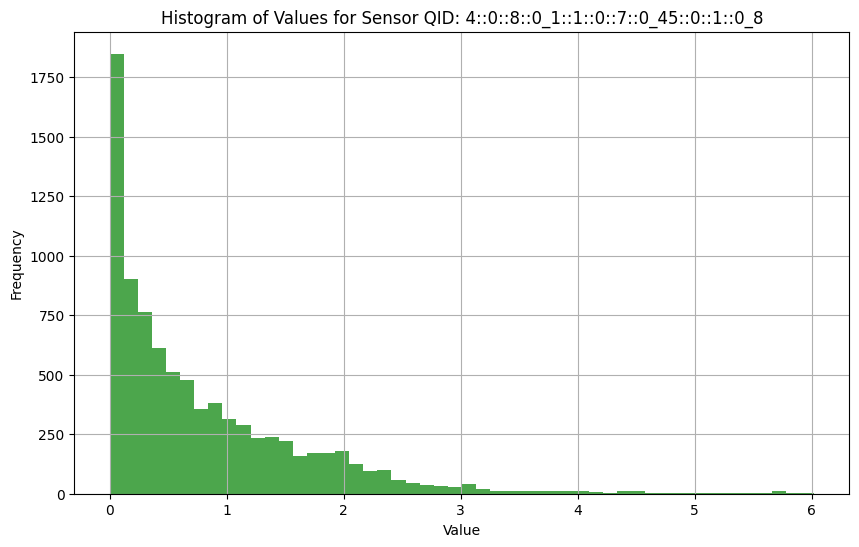

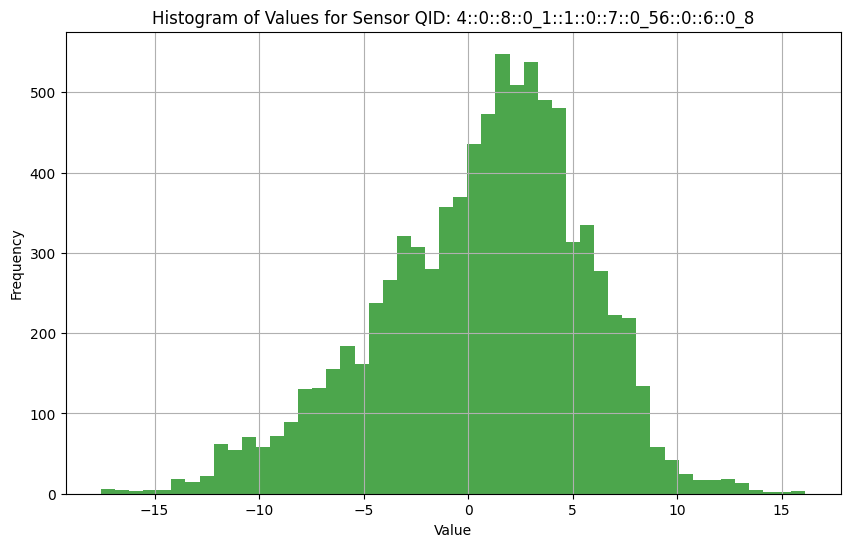

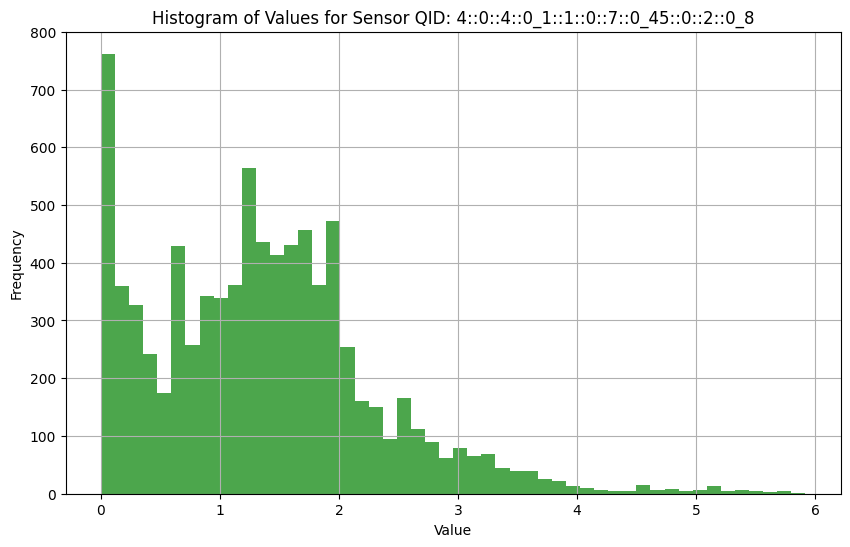

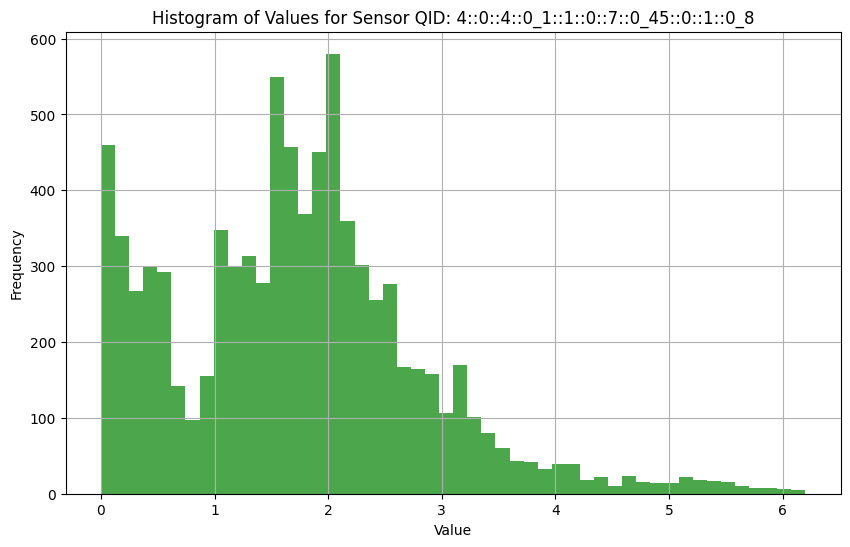

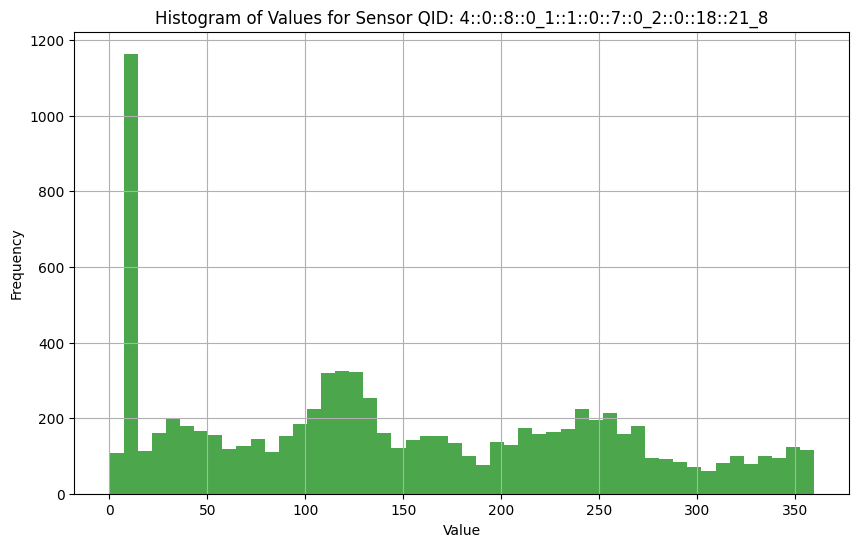

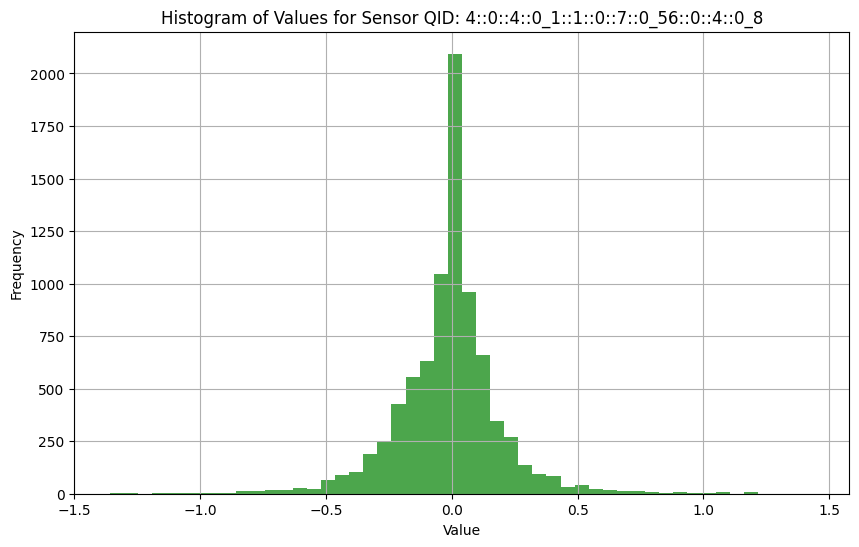

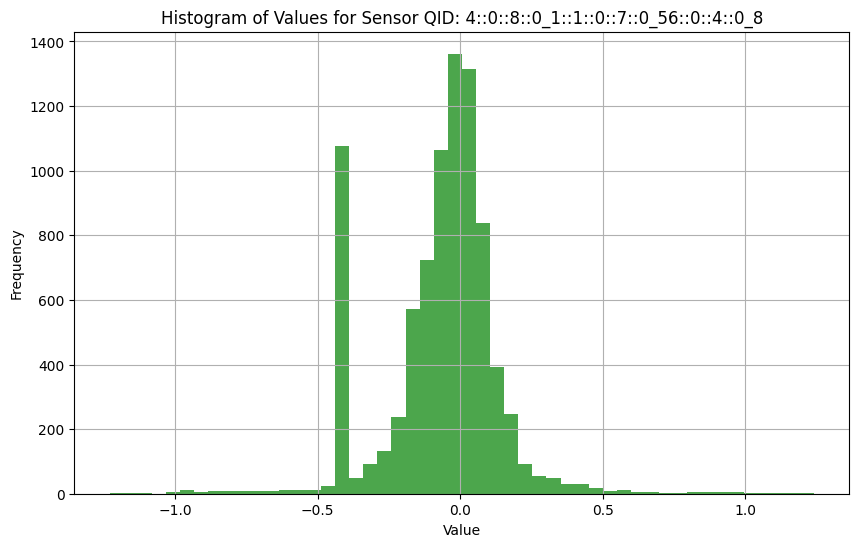

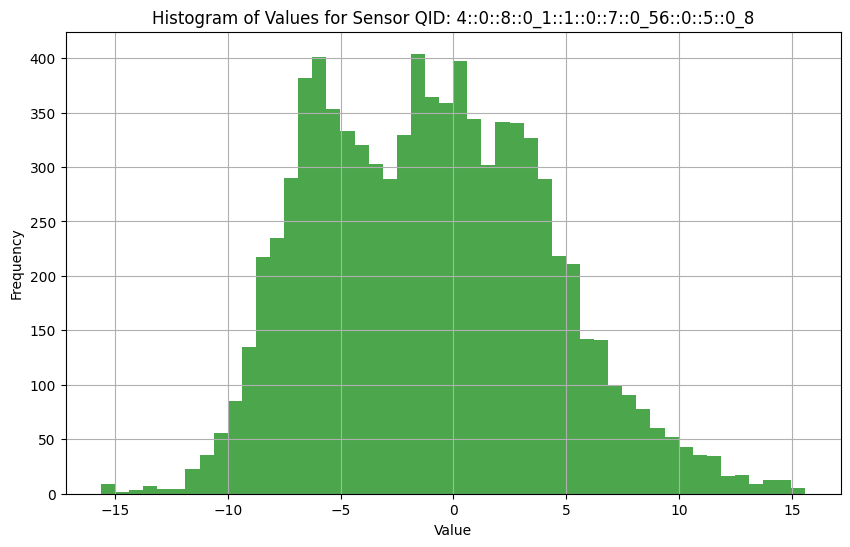

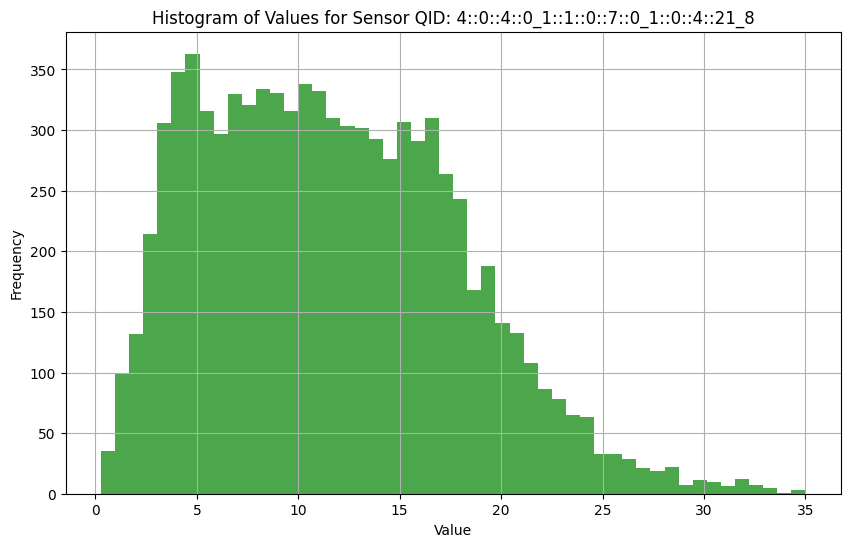

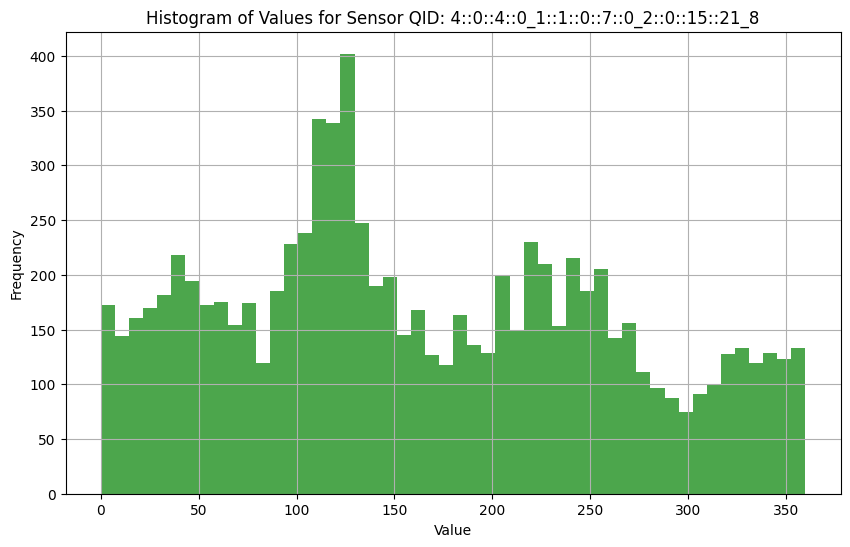

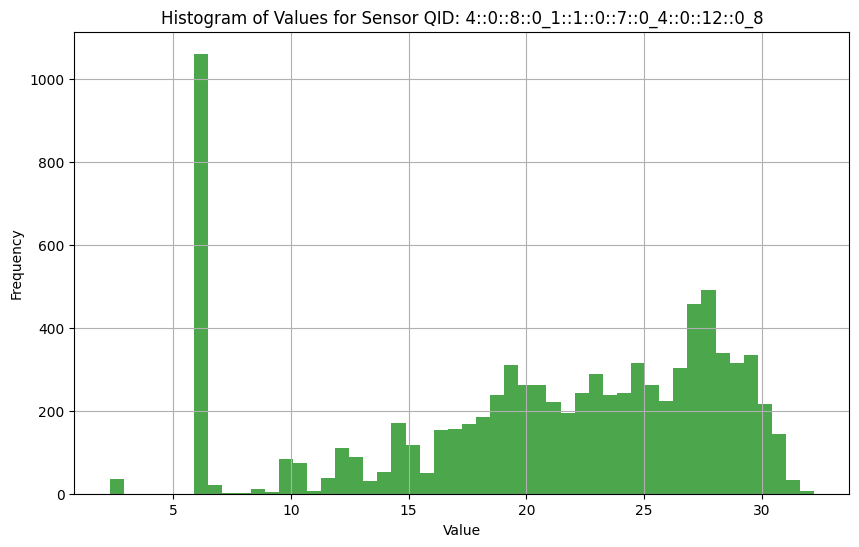

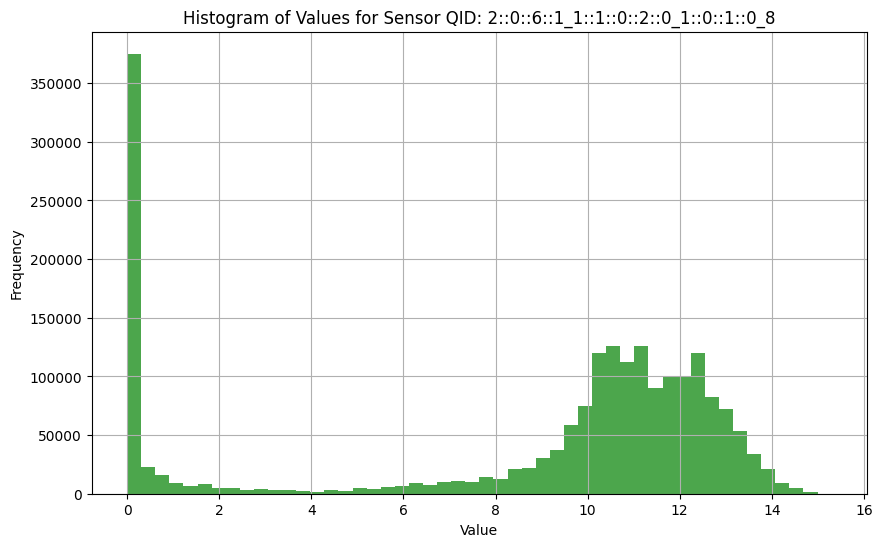

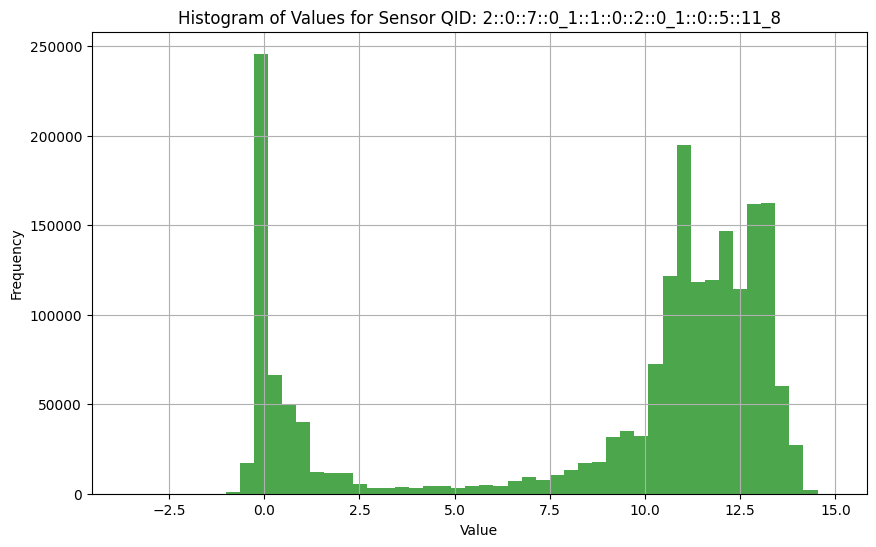

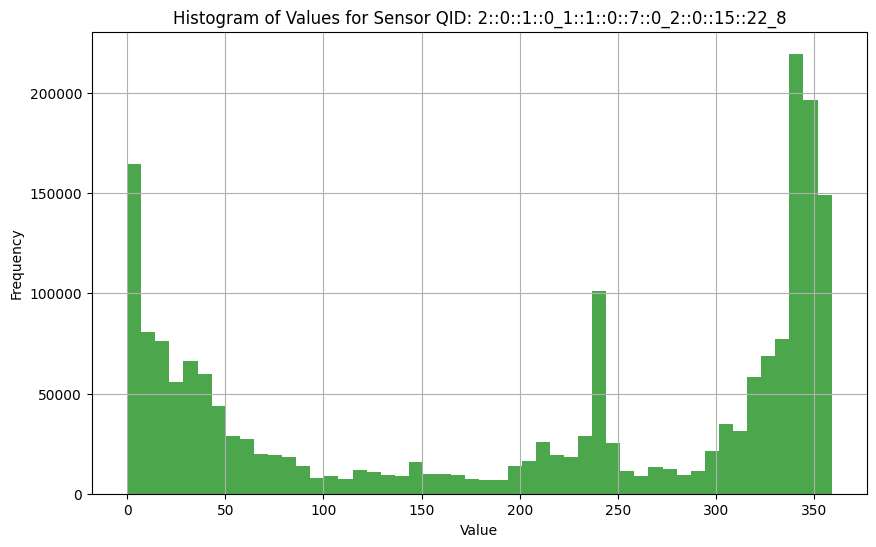

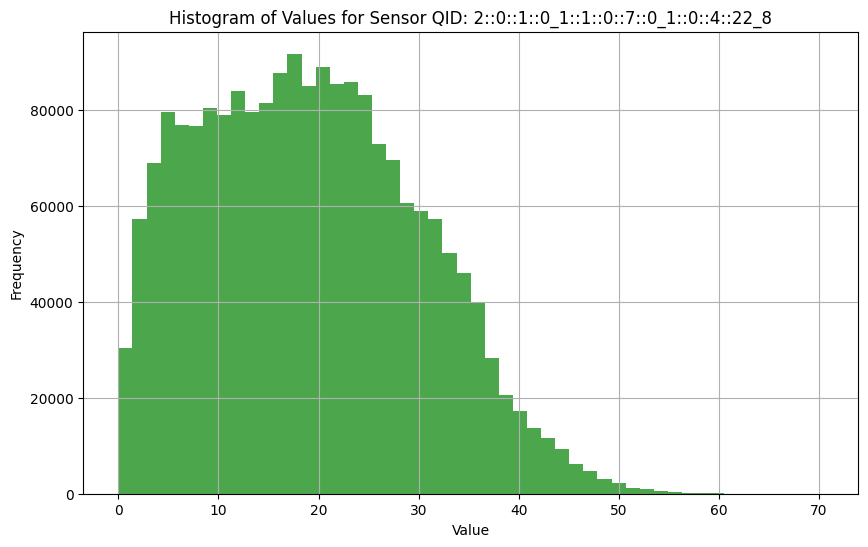

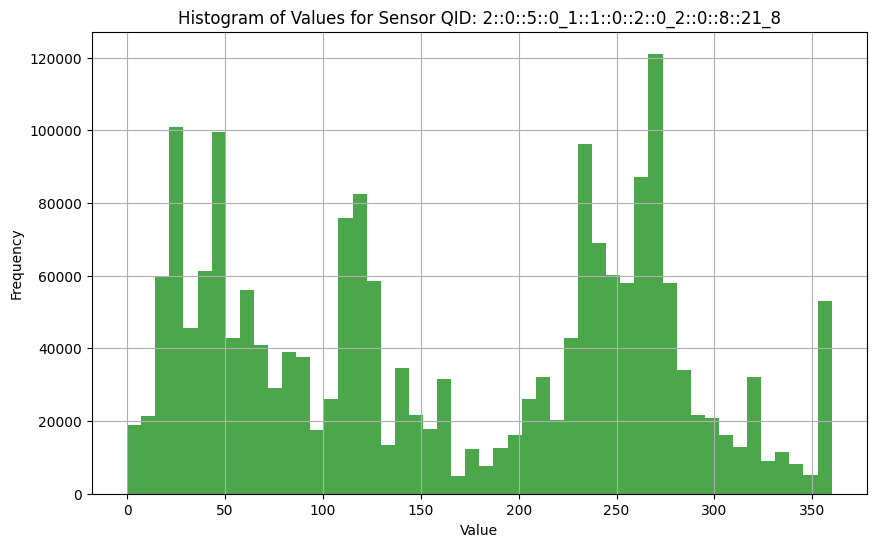

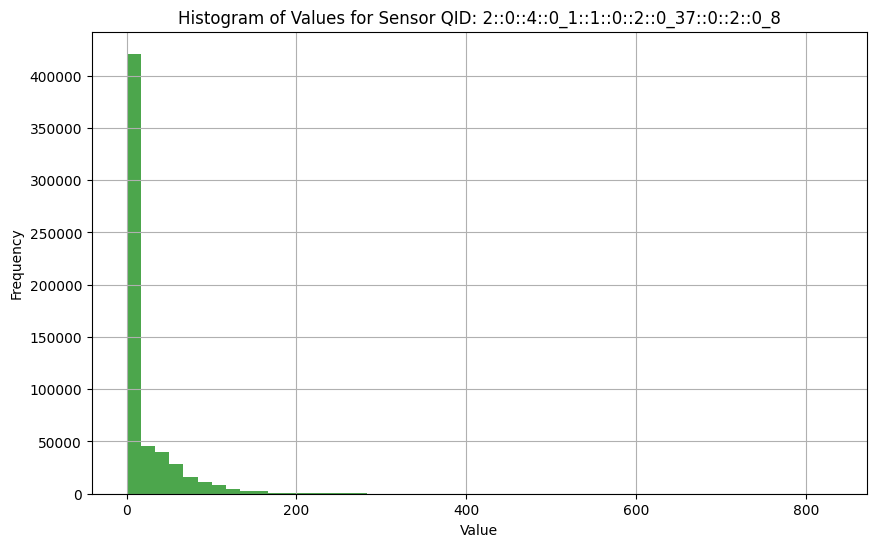

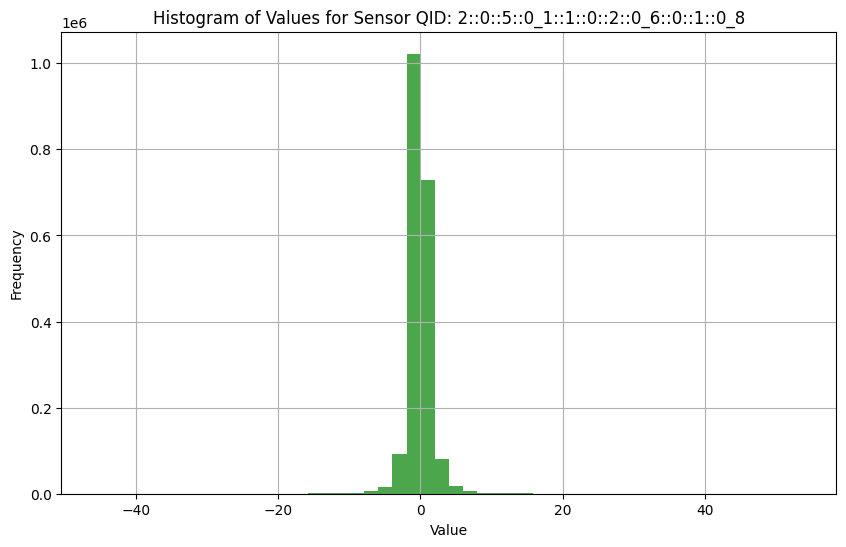

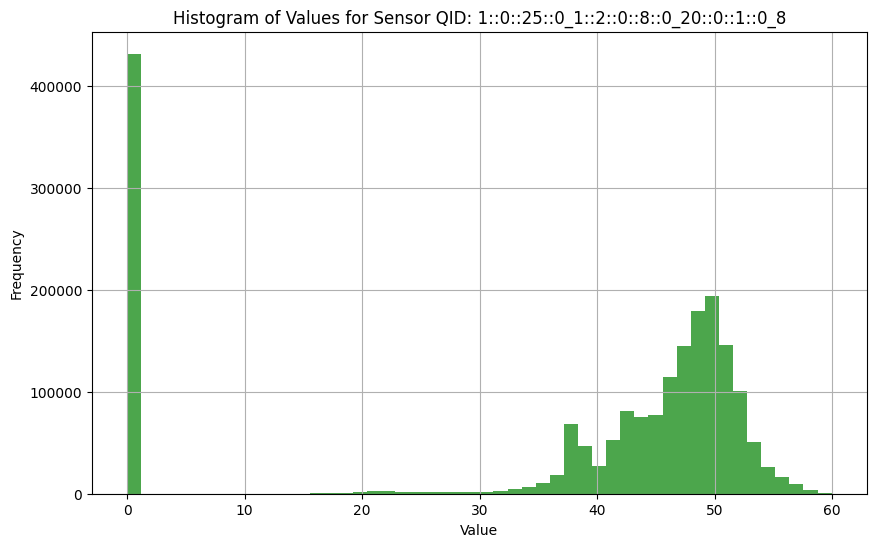

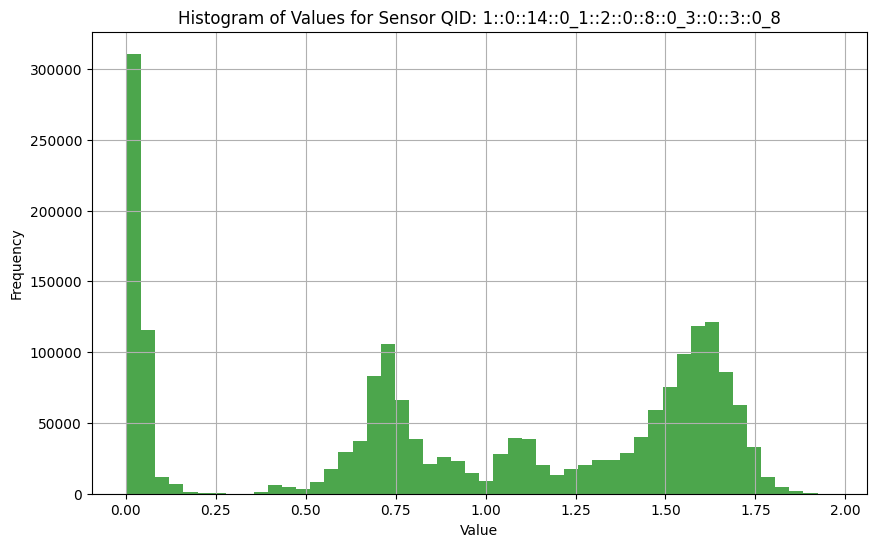

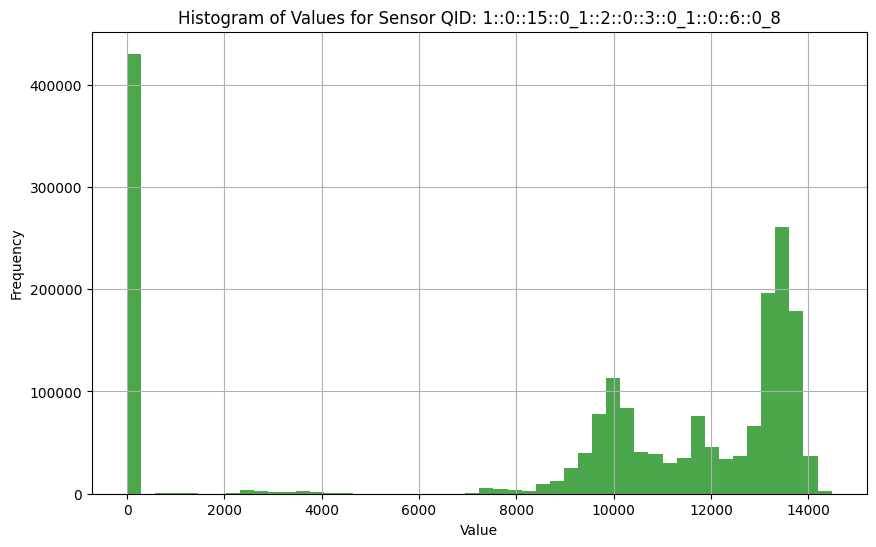

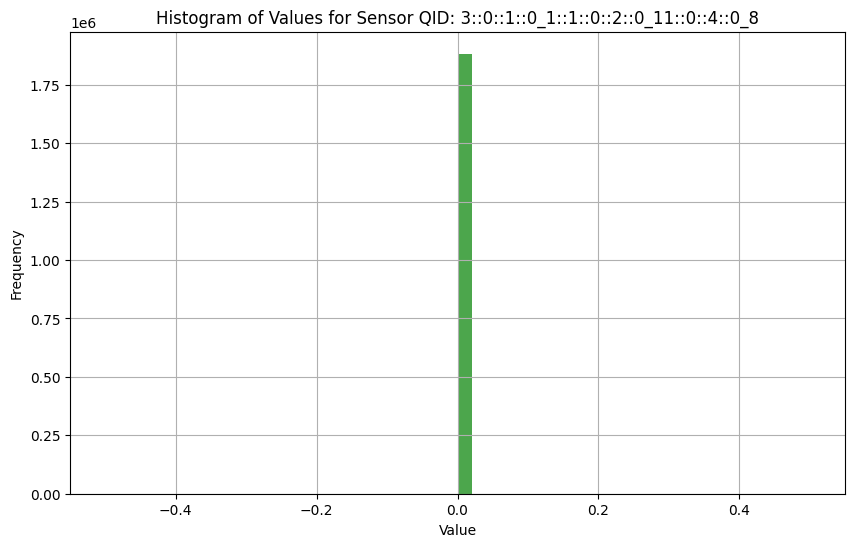

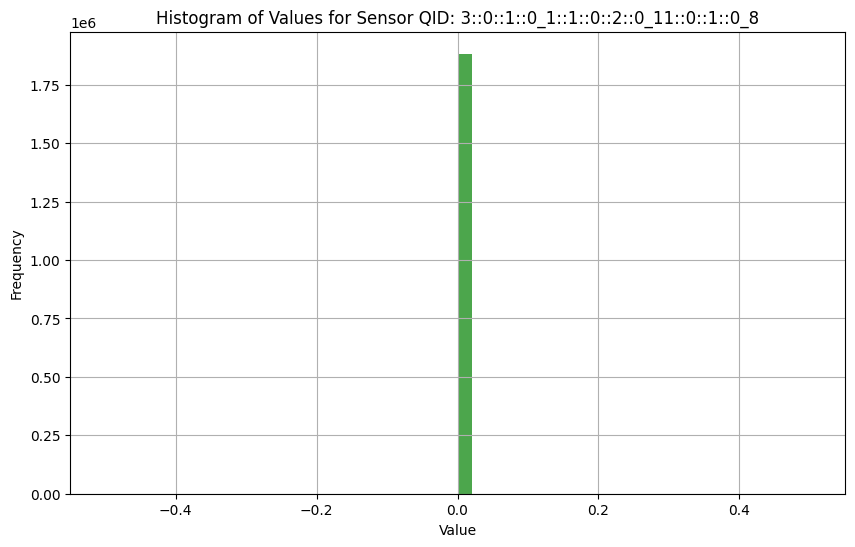

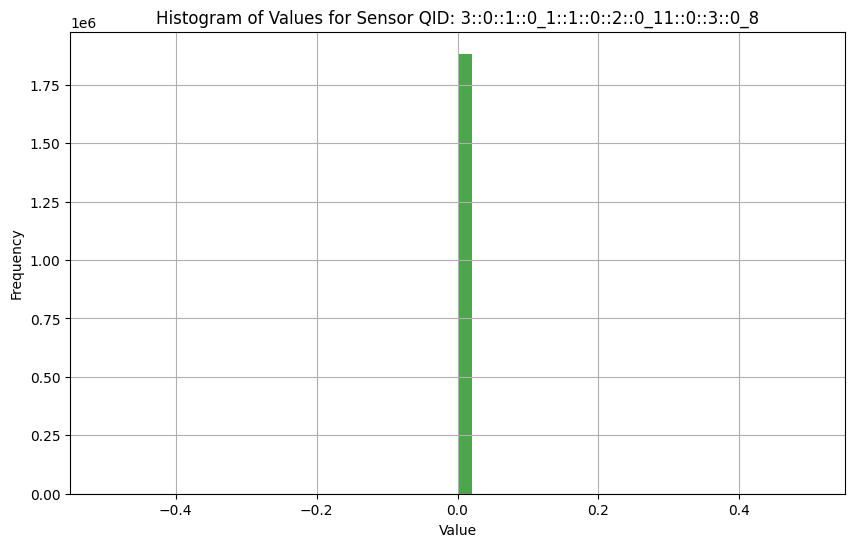

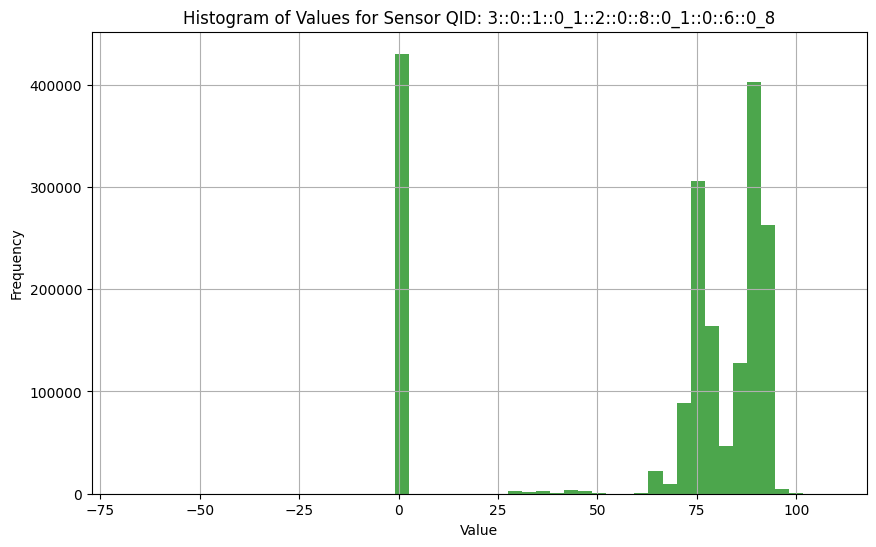

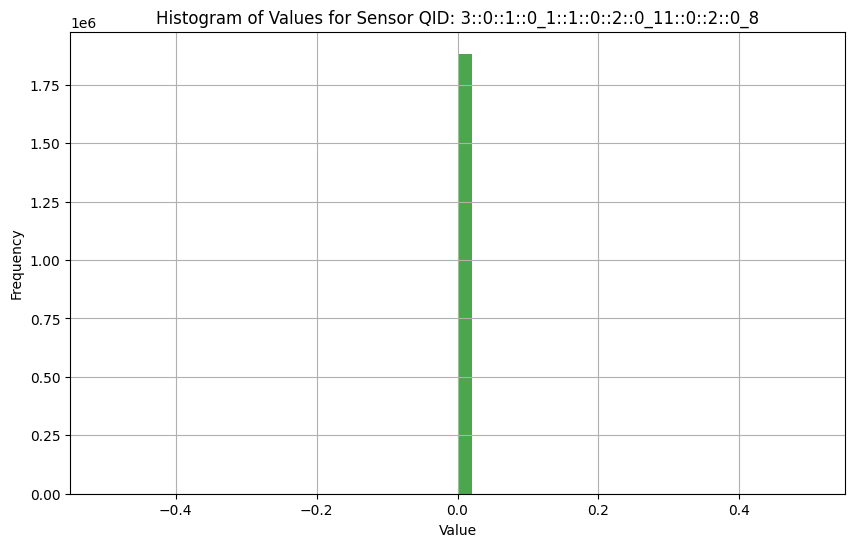

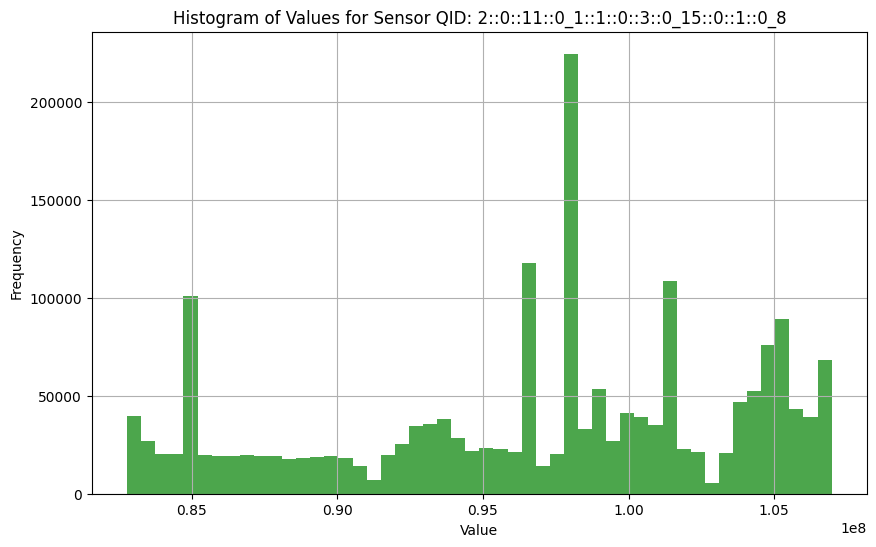

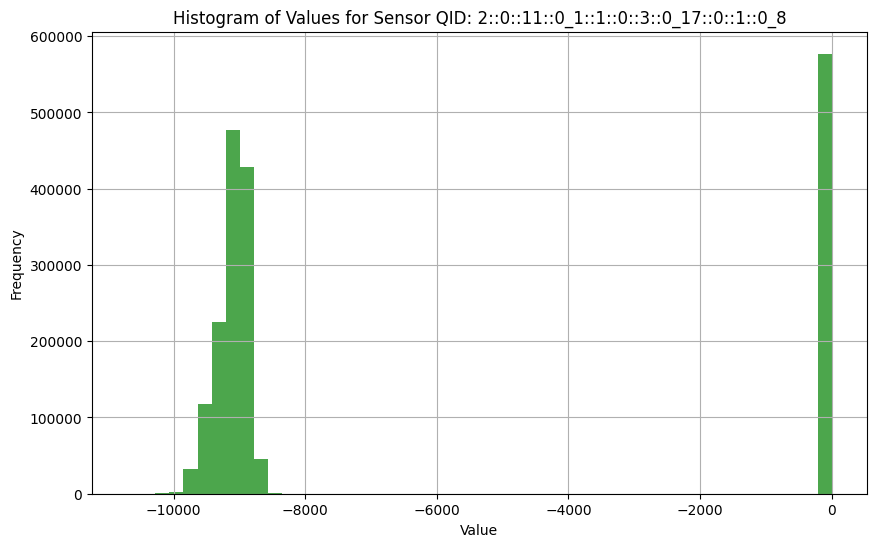

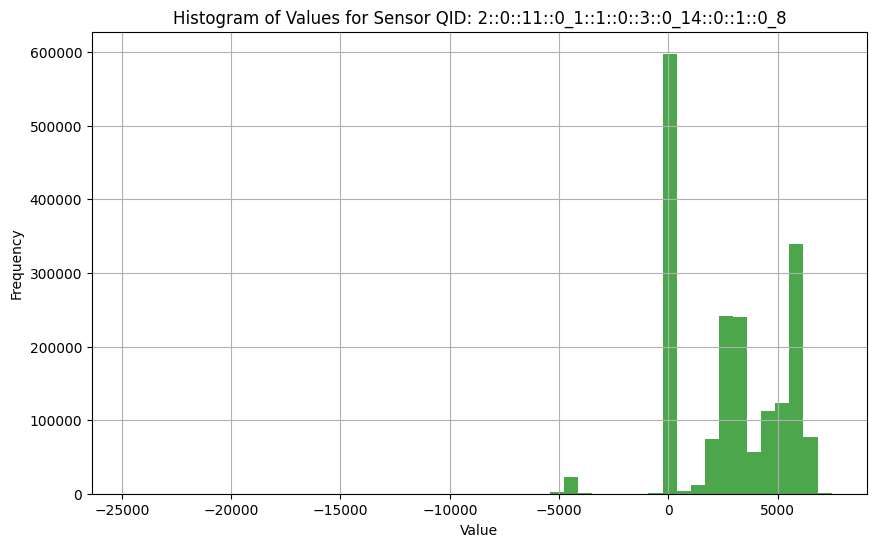

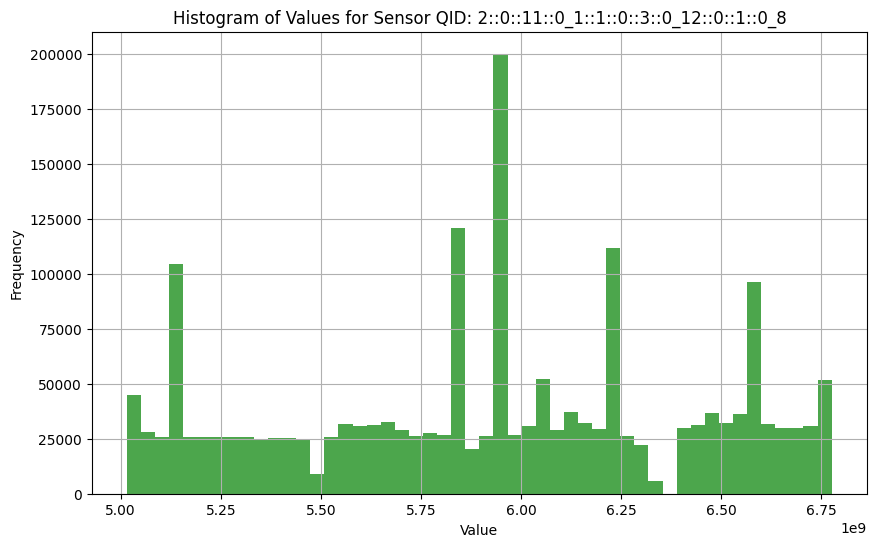

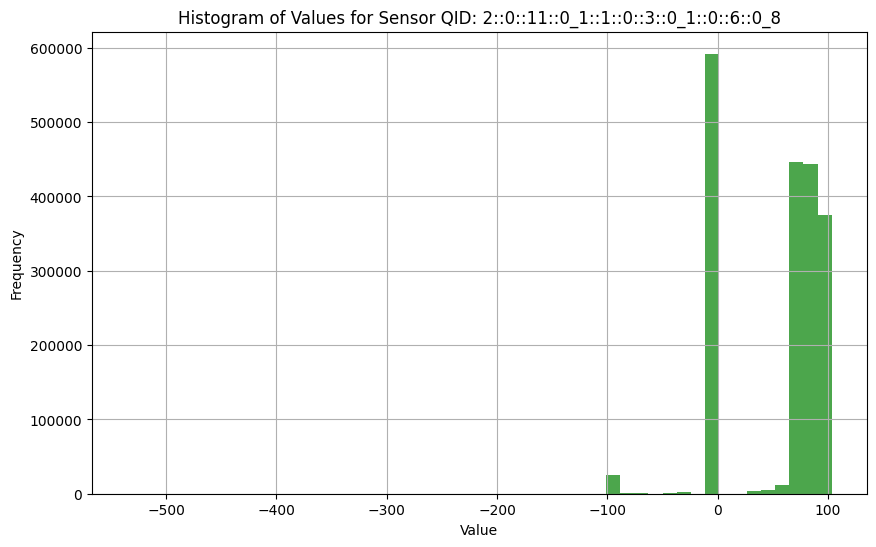

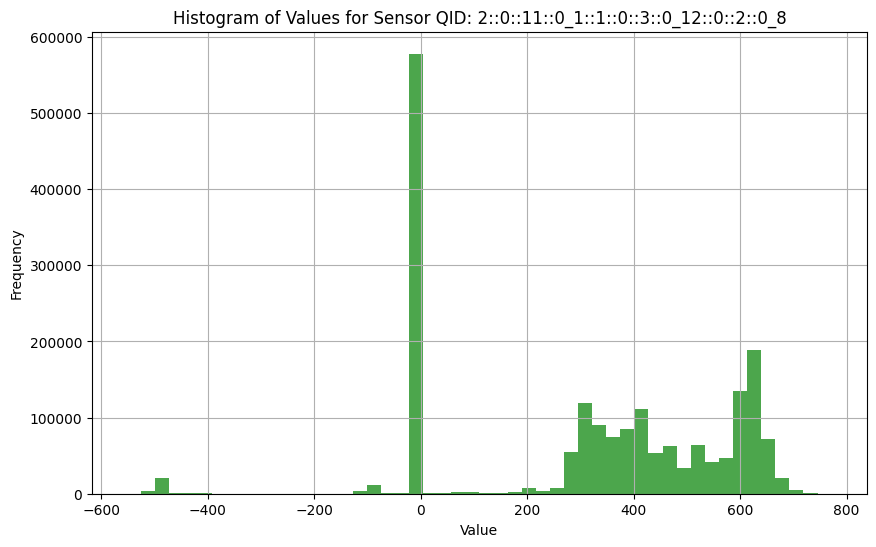

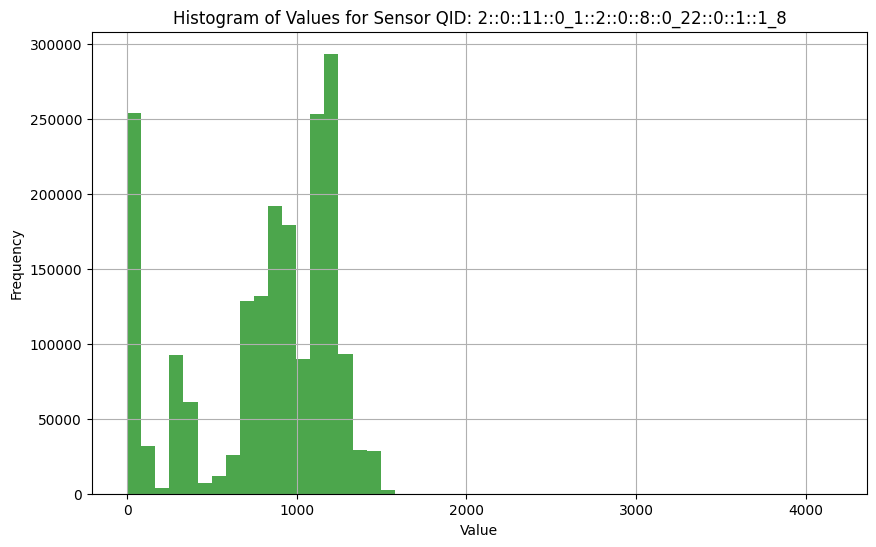

In [ ]:
# make a 3 x 12 grid and populate it with histograms showing the distribution of values for each sensor (qid_mapping)
fig, axs = plt.subplots(nrows=12, ncols=3, figsize=(30, 15))
axs = axs.flatten()

for i, qid_mapping in enumerate(df_combined['qid_mapping'].unique()):
    sensor_data = df_combined[df_combined['qid_mapping'] == qid_mapping]
    plt.figure(figsize=(10, 6))
    plt.hist(sensor_data['value'].dropna(), bins=50, color='green', alpha=0.7)
    plt.title(f'Histogram of Values for Sensor QID: {qid_mapping}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()